This is a follow up of vgg16_tests.
1. Here I instantiate the class Vgg16 from vgg16.py.
2. finetune it: remove last layer + add a two layer
3. load the fine tune model weights 'sample_02_finetune.h5'



In [1]:
# create Vgg16 model
import numpy as np
from keras.layers.core import Dense
from vgg16 import Vgg16

vgg = Vgg16()
model = vgg.model
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
__________

In [2]:
# remove last layer from model
# BE CAREFULL HERE: you can use pop() only if the model is sequential !!!!
model.pop()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
__________

In [3]:
# set all layers to trainable false
for layer in model.layers: layer.trainable=False
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
__________

In [4]:
# add only 2 classes
model.add(Dense(2, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
__________

Found 40 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


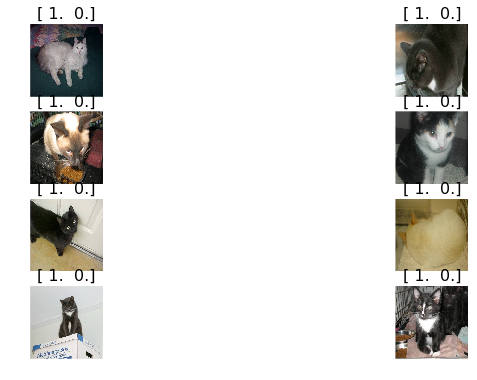

In [5]:
# Now, start working on the data
# data location (a small sample of it)
path = '/home/ubuntu/fastai/courses/deeplearning1/nbs/data/dogscats/sample/'
model_path = path + 'models/'

%matplotlib inline

# setting batch_size to 32 and continuing normaly
# depending on the system and the number of parameters to learn, the program may crashes
# on this param
batch_size = 8

from fcn_utils import get_batches, get_data, plots

val_batches = get_batches(path+'valid', shuffle=False, batch_size=batch_size)
trn_batches = get_batches(path+'train', shuffle=False, batch_size=batch_size)

# trying to understand how the batches are constructed
val_imgs, val_labels = next(val_batches) 
plots(val_imgs, titles=val_labels, figsize=(12,6), rows = 4) # plot 'batch_size = 32' images

In [6]:
# target_size=(224,224)

val_data = get_data(path+'valid') # extract the 'real' data from batches
trn_data = get_data(path+'train')

Found 40 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [7]:
from sklearn.preprocessing import OneHotEncoder

def onehot(x):
      return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())
    
val_classes = val_batches.classes
trn_classes = trn_batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)


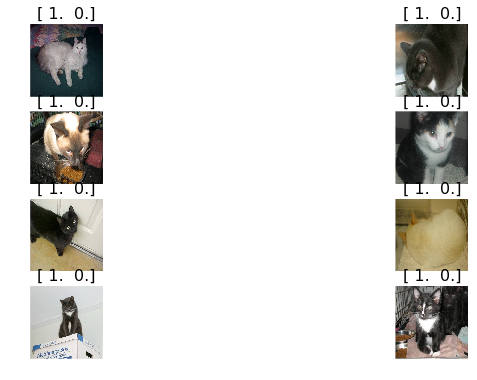

In [8]:
from keras.preprocessing import image
from keras.callbacks import TensorBoard

gen = image.ImageDataGenerator()
trn_batches = gen.flow(trn_data, trn_labels, batch_size=batch_size, shuffle=True)
val_batches = gen.flow(val_data, val_labels, batch_size=batch_size, shuffle=False) # this does not touch the validation data

# trying to understand how the batches are constructed
val_imgs, val_labels = next(val_batches) 
plots(val_imgs, titles=val_labels, figsize=(12,6), rows = 4) # plot 'batch_size = 32' images

def fit_model(model, trn_batches, val_batches, nb_epoch=1, callbacks=None):
      model.fit_generator(trn_batches, 
                          samples_per_epoch=trn_batches.n, 
                          nb_epoch=nb_epoch, 
                          validation_data=val_batches, 
                          nb_val_samples=val_batches.n,
                          callbacks=callbacks)


In [17]:
from keras.optimizers import SGD, RMSprop, Adam
# from multi_gpu import make_parallel, get_available_gpus

# available_gpus = get_available_gpus()
# print available_gpus
# model = make_parallel(model, available_gpus)
opt = Adam(lr = 1e-4)#SGD(lr=1e-3, momentum=0.9)#Adam(lr = 1e-3)#SGD(lr=1e-3, momentum=0.9)#RMSprop(lr=0.00001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
fit_model(model, 
          trn_batches, 
          val_batches, 
          nb_epoch=10,
          callbacks = [TensorBoard(log_dir='./logs/04_tensorboard', histogram_freq=1)])        

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=<keras.pre..., steps_per_epoch=25, epochs=10, callbacks=[<keras.ca..., validation_steps=40)`


INFO:tensorflow:Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.
INFO:tensorflow:Summary name conv2d_2/kernel:0 is illegal; using conv2d_2/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_2/bias:0 is illegal; using conv2d_2/bias_0 instead.
INFO:tensorflow:Summary name conv2d_3/kernel:0 is illegal; using conv2d_3/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_3/bias:0 is illegal; using conv2d_3/bias_0 instead.
INFO:tensorflow:Summary name conv2d_4/kernel:0 is illegal; using conv2d_4/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_4/bias:0 is illegal; using conv2d_4/bias_0 instead.
INFO:tensorflow:Summary name conv2d_5/kernel:0 is illegal; using conv2d_5/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_5/bias:0 is illegal; using conv2d_5/bias_0 instead.
INFO:tensorflow:Summary name conv2d_6/kernel:0 is illegal; using conv2d_6/kernel_0 instead.
INFO:ten

In [18]:
# the model bellow was fine tuned on 200 training and 40 validation samples
# 100% overfitting
model.save_weights(model_path+'sample_02_finetune.h5')

In [19]:
# from now, I add more data + load the fine tuned weights + continue fitting on this new data

# load saved model for subsample of data (200 + 40)
path = '/home/ubuntu/fastai/courses/deeplearning1/nbs/data/dogscats/sample/'
model_path = path + 'models/'

model.load_weights(model_path+'sample_02_finetune.h5')

In [20]:
# change path to full model
path = '/home/ubuntu/fastai/courses/deeplearning1/nbs/data/dogscats/'
model_path = path + 'models/'


# setting batch_size to 32 and continuing normaly
# depending on the system and the number of parameters to learn, the program may crashes
# on this param
batch_size = 8

val_batches = get_batches(path+'valid', shuffle=False, batch_size=batch_size)
trn_batches = get_batches(path+'train', shuffle=False, batch_size=batch_size)

val_data = get_data(path+'valid') # extract the 'real' data from batches
trn_data = get_data(path+'train')

val_classes = val_batches.classes
trn_classes = trn_batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

gen = image.ImageDataGenerator()
trn_batches = gen.flow(trn_data, trn_labels, batch_size=batch_size, shuffle=True)
val_batches = gen.flow(val_data, val_labels, batch_size=batch_size, shuffle=False) # this does not touch the valid


Found 4000 images belonging to 2 classes.
Found 21000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 21000 images belonging to 2 classes.


In [21]:
opt = Adam(lr = 1e-4)#SGD(lr=1e-3, momentum=0.9)#Adam(lr = 1e-3)#SGD(lr=1e-3, momentum=0.9)#RMSprop(lr=0.00001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
fit_model(model, 
          trn_batches, 
          val_batches, 
          nb_epoch=10,
          callbacks = [TensorBoard(log_dir='./logs/05_tensorboard', histogram_freq=1)])        

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=<keras.pre..., steps_per_epoch=2625, epochs=10, callbacks=[<keras.ca..., validation_steps=4000)`


INFO:tensorflow:Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.
INFO:tensorflow:Summary name conv2d_2/kernel:0 is illegal; using conv2d_2/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_2/bias:0 is illegal; using conv2d_2/bias_0 instead.
INFO:tensorflow:Summary name conv2d_3/kernel:0 is illegal; using conv2d_3/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_3/bias:0 is illegal; using conv2d_3/bias_0 instead.
INFO:tensorflow:Summary name conv2d_4/kernel:0 is illegal; using conv2d_4/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_4/bias:0 is illegal; using conv2d_4/bias_0 instead.
INFO:tensorflow:Summary name conv2d_5/kernel:0 is illegal; using conv2d_5/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_5/bias:0 is illegal; using conv2d_5/bias_0 instead.
INFO:tensorflow:Summary name conv2d_6/kernel:0 is illegal; using conv2d_6/kernel_0 instead.
INFO:ten

KeyboardInterrupt: 

In [22]:
# save the full model
model.save_weights(model_path+'sample_03_finetune.h5')